# Getting started with `pythonradex`

`pythonradex` is used to solve the non-LTE radiative transfer in a 1D geometry. It can include effects of dust continuum and overlapping lines. Here we look at the main functionalities provided by pythonradex.

Note that all input and output for `pythonradex` is in SI units.

## Initialisation

In `pythonradex`, a radiative transfer calculation is conducted using the `Source` class which is provided by the `radiative_transfer` module. Let's have a look how to initialise it. Please refer to the API for more details

In [1]:
from pythonradex import radiative_transfer, helpers
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt

First we need to initialise an instance of the `Source` class. The input parameters are as follows:

* `datafilepath`: Filepath to the file containing molecular data. The file needs to follow the [LAMDA format](https://home.strw.leidenuniv.nl/~moldata/molformat.html) and is usually downloaded from the [EMAA database](https://emaa.osug.fr/) or the [LAMDA database](https://home.strw.leidenuniv.nl/~moldata/).
* `geometry`: The geometry of the source. Please see the documentation for more details about the geometries. Available options: 'static sphere', 'static slab', 'LVG slab', 'LVG sphere', 'static sphere RADEX' (emulating RADEX), 'LVG sphere RADEX' (emulating RADEX).
* `line_profile_type`: The shape of the intrinsic emission line profile. Available options: 'rectangular' and 'Gaussian'. Note that for LVG geometries, only rectangular is allowed.
* `width_v`: The width of the emission line in velocity space. For a Gaussian, this corresponds to the FWHM. Note that pythonradex uses SI units, so this needs to be given in m/s.
* `use_Ng_acceleration`: Whether to use Ng acceleration to speed up convergence. Defaults to True.
* `treat_line_overlap`: Whether to treat line overlap effects (i.e. emission lines that overlap in frequency). This option is computationally expensive. Not allowed for LVG geometries. Defaults to False. There is a dedicated example notebook demonstrating this capability.
* `warn_negative_tau`: Whether to throw a warning in the case where negative optical depth occurs for any transition. Defaults to True.
* `verbose`: Whether to print out additional info. Defaults to False.
* `test_mode`: Whether to activate test mode. Only for developers, should be left to its default, i.e. False.

Let's initialise a source. In this example, we consider CO. We leave some parameters at their default values.

In [2]:
datafilepath = "./co.dat"  # CO
geometry = "static sphere"
line_profile_type = "Gaussian"
width_v = 1.5 * constants.kilo  # 1500 m/s = 1.5 km/s

source = radiative_transfer.Source(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

## Setting the source parameters

Next, we are going to set the parameters characterising the source physical conditions. These parameters are:

* `N`: The column density, in units of m$^{-2}$.
* `Tkin`: The kinetic temperature of the gas in units of K.
* `collider_densities`: The number density of colliders, in dictionary format, in units of m$^{-3}$. The following colliders are recognised: "H2", "para-H2", "ortho-H2", "e", "H", "He", "H+". Obviously, only colliders present in the data file can be used here.
* `ext_background`: The external background radiation. This is the radiation field that irradiates the source from the exterior and can affect the excitation conditions. The user can provide a custom radiation field by providing a function that takes a frequency array as input and returns the radiation field in units of W/m$^2$/Hz/sr. The commonly used CMB background can by used via the helpers module. One can also set this parameter to a number, which is interpreted as a constant value for all frequencies. So if no external background is desired, simply set this parameter to 0. Examples: `ext_background = lambda nu: helpers.B_nu(nu=nu,T=200)` (a black body at 200 K); `ext_background = 0` (no external background); `ext_background = helpers.generate_CMB_background(z=1.3)` (CMB at redshift 1.3).
* `T_dust`: Temperature of the dust continuum radiation field, which is internal to the source (i.e. the dust is mixed with the gas). The dust temperature defines the source function of the field by setting it equal to the Planck law (black body). The user can provide a custom function, which should take an array of frequencies as input. One can also provide a number, which is interpreted as constant value. Thus, for a model without dust, simply put this parameter to 0. Note that there is a dedicated notebook discussing dust effects. Examples: `T_dust = lambda nu: 100*nu/(230*constants.giga)` (dust temperature proportional to frequency, 100 K at 230 GHz); `T_dust = 80` (constant dust temperature for all frequencies); `T_dust = 0` (no dust)
* `tau_dust`: The optical depth of the dust. Same as `T_dust`, this can be given as a function of frequency, or as a single number (constant value). Example: `tau_dust=0` (no dust)

To set these parameters, we use the `update_parameters` method. When called for the first time, all parameters need to be specified. Subsequently, if the user wishes to run another calculation with different parameters, the same method can be used to update only a subset of parameters.

In [3]:
N = 1e16 / constants.centi**2  # 1e16 cm-2 in units of m-2
Tkin = 120
# For CO, para-H2 and ortho-H2 are available as colliders:
collider_densities = {
    "para-H2": 1e4 / constants.centi**3,
    "ortho-H2": 3e4 / constants.centi**3,
}
ext_background = helpers.generate_CMB_background(z=1.3)  # CMB at redshift 1.3
T_dust, tau_dust = 0, 0  # no dust

source.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

## Solve the radiative transfer

Next, we solve the radiative transfer (i.e. calculate the level population with an iterative method):

In [4]:
source.solve_radiative_transfer()

## Inspect the results

### Level population, excitation temperature, optical depth at $\nu_0$

Let's inspect some basic results of the calculation: the level population, excitation temperature and optical depth at the rest frequency

In [5]:
# fractional level population of the 2rd and 5th levels (as listed in the LAMDA-formatted data file),
# thus indices are 1 and 4
level_indices = (1, 4)
for i in level_indices:
    level_pop = source.level_pop[i]
    print(f"fractional population of level {i}: {level_pop:.2g}")
# find the level with the highest fractional population:
most_populated_level = np.argmax(source.level_pop)
max_level_pop = np.max(source.level_pop)
print(
    f"level {most_populated_level} is the most populated"
    + f" (fractional level population = {max_level_pop:.3g})"
)

fractional population of level 1: 0.11
fractional population of level 4: 0.19
level 3 is the most populated (fractional level population = 0.203)


There is also a way to easily check the fractional level population of a given transition. For example, let's check the populations for CO 3-2:

In [6]:
index_CO32 = 2  # CO 3-2 is the 3rd transtion in the LAMDA file, so its index is 2 (first index is 0)
CO32_low_pop = source.lower_level_population[index_CO32]
CO32_up_pop = source.upper_level_population[index_CO32]
print(f"fractional population of lower level of CO 3-2: {CO32_low_pop:.3g}")
print(f"fractional population of upper level of CO 3-2: {CO32_up_pop:.3g}")

fractional population of lower level of CO 3-2: 0.171
fractional population of upper level of CO 3-2: 0.203


The optical depth at the rest frequency $\nu_0$ we calculate next does not include the contribution of dust or overlapping lines; it is just the optical depth of the requested transition, not the total optical depth.

In [7]:
# let's consider the 3rd and 6th transition in the LAMDA-formatted
# file (CO 2-1, CO 3-2 and CO 6-5), with indices 1, 2 and 5
transition_indices = (1, 2, 5)
for i in transition_indices:
    tau_nu0 = source.tau_nu0_individual_transitions[i]
    Tex = source.Tex[i]
    print(f"transition {i}: Tex = {Tex:.3g} K, tau_nu0 = {tau_nu0:.3g}")

transition 1: Tex = 174 K, tau_nu0 = 0.0425
transition 2: Tex = 99.9 K, tau_nu0 = 0.149
transition 5: Tex = 47.5 K, tau_nu0 = 0.364


### Frequency-integrated emission

Let's first look at the frequency-integrated emission of some transitions we are interested in. For example, imaging we are interested in CO 1-0 and CO 4-3. In the LAMDA-formatted data file, these two transitions appear in 1st and 4st position, so their indices are 0 and 3. Note that this calculation is only possible if the dust is optically thin or absent. Similarly, if there are overlapping lines, the calculation is only possible if all overlapping lines are optically thin.

If we want to calculate the flux (i.e. W/m<sup>2</sup>), we also need to define the solid angle of the source.

In [8]:
flux_transitions = [0, 3]  # the indices of the transitions we want the flux for
R = 10 * constants.au  # assume our sphere has a radius of 10 au
distance = 100 * constants.parsec  # assume the source is at a distance of 100 pc

output_types = ("intensity", "flux")
units = ("W/m2/sr", "W/m2")
solid_angles = (
    None,
    R**2 * np.pi / distance**2,
)  # intensity does not need a solid angle, so we set it to None
for output_type, unit, solid_angle in zip(output_types, units, solid_angles):
    flux = source.frequency_integrated_emission(
        output_type=output_type, transitions=flux_transitions, solid_angle=solid_angle
    )
    for index, f in zip(flux_transitions, flux):
        print(f"{output_type} of transition {index}: {f:.3g} {unit}")

intensity of transition 0: 3.18e-12 W/m2/sr
intensity of transition 3: 1.74e-09 W/m2/sr
flux of transition 0: 2.35e-24 W/m2
flux of transition 3: 1.29e-21 W/m2


### Emission at the line center

We can also check the emission at the line center. This includes any contribution from dust or overlapping lines. We can request specific intensity (W/m<sup>2</sup>/Hz/sr), flux density (W/m<sup>2</sup>/Hz), Rayleigh-Jeans brightness temperature or Planck brightness temperature (both in K).

In [9]:
output_types = ("specific intensity", "flux density", "Rayleigh-Jeans", "Planck")
units = ("W/m2/Hz/sr", "W/m2/Hz", "K", "K")
for output_type, unit in zip(output_types, units):
    # only flux density needs a solid angle:
    solid_angle = R**2 * np.pi / distance**2 if output_type == "flux density" else None
    # we consider CO 2-1, which has index 1
    emission_nu0 = source.emission_at_line_center(
        output_type=output_type, solid_angle=solid_angle, transitions=1
    )
    print(f"{output_type} at line center of CO 2-1: {emission_nu0:.3g} {unit}")

specific intensity at line center of CO 2-1: 7.69e-17 W/m2/Hz/sr
flux density at line center of CO 2-1: 5.68e-29 W/m2/Hz
Rayleigh-Jeans at line center of CO 2-1: 4.71 K
Planck at line center of CO 2-1: 9.15 K


### Spectrum and total optical depth

We can also request a spectrum of emission (i.e. emission as function of frequency) and the total optical depth at arbitrary frequencies. It is often easiest to define a range of velocities and convert it to a frequency range. For the emission, we can request specific intensity (W/m<sup>2</sup>/Hz/sr), flux density (W/m<sup>2</sup>/Hz), Rayleigh-Jeans brightness temperature or Planck brightness temperature (both in K).

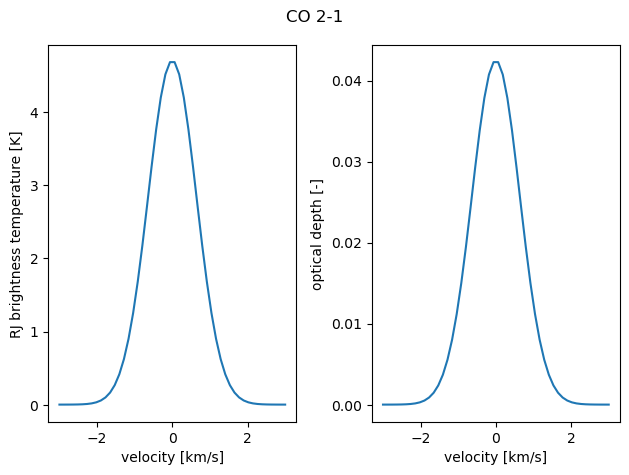

In [10]:
v = np.linspace(-2 * width_v, 2 * width_v, 50)  # m/s
# retrieve the rest frequency of CO 2-1
nu0 = source.emitting_molecule.nu0[1]  # Hz
nu = nu0 * (1 - v / constants.c)  # Hz
# total optical depth as function of nu, including dust
# and overlapping lines if present
tau = source.tau(nu=nu)
# total sprectrum (including dust and overlapping lines if present):
# we choose the output in the form of the Rayleigh-Jeans brightness temperature
# other options are "Planck" (Planck brightness temperture), "specific intensity" (W/m2/Hz/sr),
# and "flux density" (W/m2/Hz; for this option, a solid_angle needs to be provided)
spectrum = source.spectrum(output_type="Rayleigh-Jeans", nu=nu)

fig, axes = plt.subplots(ncols=2)
fig.suptitle("CO 2-1")
axes[0].plot(v / constants.kilo, spectrum)
axes[0].set_ylabel(r"RJ brightness temperature [K]")
axes[1].plot(v / constants.kilo, tau)
axes[1].set_ylabel("optical depth [-]")

for ax in axes:
    ax.set_xlabel("velocity [km/s]")
fig.tight_layout()

### printing an overview of the results

An overview of the results can be printed to the console. For each transition, it lists the indices of the upper and lower level, the rest frequency, the excitation temperature, the fractional population of the lower and upper level, and the optical depth of the transition at the rest frequency

In [11]:
source.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202     322.57      0.0371245        0.10948     0.00597971
   2    1     230.538000     174.39        0.10948        0.17125      0.0424729
   3    2     345.795990      99.95        0.17125        0.20307       0.148725
   4    3     461.040768      69.91        0.20307       0.190258       0.297295
   5    4     576.267931      55.49       0.190258       0.141269       0.390985
   6    5     691.473076      47.53       0.141269       0.083057       0.364103
   7    6     806.651806      43.71       0.083057      0.0395288       0.246477
   8    7     921.799700      43.18      0.0395288      0.0160823       0.126382
   9    8    1036.912393      44.74      0.0160823     0.00590993      0.0532576
  10    9    1151.985452      47.16     0.00590993     0.00202249      0.0199245
  11   10    1267.014486      49.99     0.00202249    0.000656319     0.00689005
  12   11    1381.995105   

## Change the source parameters

We can update the source parameters for another calculation using the `update_parameters` method. We can update a single parameter, or several parameters at the same time. We can update the column density, kinetic gas temperature, collider densities, external background, dust temperature and dust optical depth.

**IMPORTANT**: If you want to run `pythonradex` for a grid of parameters, **do not initialise a new `Source` instance for each set of parameters!** This is because setting up a new `Source` is computationally expensive, so the grid search will take much more time than needed. Instead, use the `update_parameters` method. Another notebook with an example grid search is available in the documentation.

For example, let's change the kinetic temperature and solve again:

In [12]:
new_Tkin = 20
source.update_parameters(Tkin=new_Tkin)
source.solve_radiative_transfer()

for i in transition_indices:
    tau_nu0 = source.tau_nu0_individual_transitions[i]
    Tex = source.Tex[i]
    print(f"transition {i}: Tex = {Tex:.3g} K, tau_nu0 = {tau_nu0:.3g}")

transition 1: Tex = 19.2 K, tau_nu0 = 0.899
transition 2: Tex = 17.7 K, tau_nu0 = 1.05
transition 5: Tex = 14.1 K, tau_nu0 = 0.0439


The excitation temperatures are now much lower, as one might expected.